### Import libraries

In [46]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Functions

In [47]:
# variable plotting

def attribute_plot(data, time, attribute, plot_name):
    plt.figure(figsize=(10,5))
    plt.plot(data[time], data[attribute])
    #labels = data[time]
    #plt.legend()
    plt.xlabel(xlabel=time)
    plt.ylabel(ylabel=attribute)
    #plt.xticks(data[time], labels, rotation='vertical')
    plt.title(label=plot_name)
    plt.grid(True)
    
# distribution plotting

def distribution(data, attribute, title):
    plt.figure(figsize=(10,5))
    sns.histplot(data[attribute], alpha=0.5)
    plt.axvline(data[attribute].median(), color='r', linestyle='dashed', linewidth=2, label='median value')
    plt.axvline(data[attribute].mean(), color='purple', linestyle='dashed', linewidth=2, label='average value')
    plt.axvline(data[attribute].quantile(0.25), color='r', linestyle='dotted', linewidth=3, label='25% and 75% values')
    plt.axvline(data[attribute].quantile(0.75), color='r', linestyle='dotted', linewidth=3)
    plt.legend()
    plt.title(label=title)
    plt.show()

### Import dependencies

In [48]:
data = pd.read_csv('train_data.csv')
print(data.shape)

(375734, 246)


In [49]:
data = data.drop(columns='index')

### Data types verification

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 245 entries, lat to wind-vwnd-925-2010-20
dtypes: float64(240), int64(3), object(2)
memory usage: 702.3+ MB


In [51]:
data.dtypes

lat                                   float64
lon                                   float64
startdate                              object
contest-pevpr-sfc-gauss-14d__pevpr    float64
nmme0-tmp2m-34w__cancm30              float64
                                       ...   
wind-vwnd-925-2010-16                 float64
wind-vwnd-925-2010-17                 float64
wind-vwnd-925-2010-18                 float64
wind-vwnd-925-2010-19                 float64
wind-vwnd-925-2010-20                 float64
Length: 245, dtype: object

In [52]:
# change date format from 'object' to 'datetime'

data['startdate'] = pd.to_datetime(data['startdate'])
data.dtypes

lat                                          float64
lon                                          float64
startdate                             datetime64[ns]
contest-pevpr-sfc-gauss-14d__pevpr           float64
nmme0-tmp2m-34w__cancm30                     float64
                                           ...      
wind-vwnd-925-2010-16                        float64
wind-vwnd-925-2010-17                        float64
wind-vwnd-925-2010-18                        float64
wind-vwnd-925-2010-19                        float64
wind-vwnd-925-2010-20                        float64
Length: 245, dtype: object

In [53]:
# what feature has type 'object' besides the date?

data.select_dtypes(include=['object'])

,climateregions__climateregion
0,BSh
1,BSh
2,BSh
3,BSh
4,BSh
...,...
375729,Dfb
375730,Dfb
375731,Dfb
375732,Dfb


### Missing values and duplicates check

In [54]:
data.isna().sum().any()

True

In [55]:
data.duplicated().any()

False

In [56]:
missing_values = data.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64

There are 8 variables with missing values. All of them related to weather models forecasting.

### Features description

Date: startdate

Static features
Geoposition: lat, lon, elevation__elevation, climateregions__climateregion

Dynamics features

1. Environmental features (humidity, pressure, water): contest-pevpr-sfc-gauss-14d__pevpr – evaporation, contest-rhum-sig995-14d__rhum – relative humidity, contest-slp-14d__slp – sea level pressure, contest-pres-sfc-gauss-14d__pres – pressure, contest-prwtr-eatm-14d__prwtr – precipitable water for entire atmosphere, contest-precip-14d__precip – measured precipitation

2. Wind:
- Longitudinal wind: contest-wind-vwnd-925-14d__wind-vwnd-925, contest-wind-vwnd-250-14d__wind-vwnd-250
- Zonal wind: contest-wind-uwnd-250-14d__wind-uwnd-250, contest-wind-uwnd-925-14d__wind-uwnd-925
- Geopotential height wind: contest-wind-h10-14d__wind-hgt-10 – height 10,contest-wind-h100-14d__wind-hgt-100  – height 100, contest-wind-h500-14d__wind-hgt-500 – height 500, contest-wind-h850-14d__wind-hgt-850 – height 850

3. Temperature - target: the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date: contest-tmp2m-14d__tmp2m 

4. Temperature computed by weather models:
- recent forecasts from different weather models: cancm30, cancm40, ccsm30, ccsm40, cfsv20, gfdlflora0, gfdlflorb0, gfdl0, nasa0, nmme0mean
- sea surface temperature: sst-2010-1 - sst-2010-10
- most recent monthly NMME model forecasts for target and average forecast across those models (nmme0mean): nmme0-tmp2m-34w__cancm30, nmme0-tmp2m-34w__cancm40, nmme0-tmp2m-34w__ccsm30, nmme0-tmp2m-34w__ccsm40, nmme0-tmp2m-34w__cfsv20, nmme0-tmp2m-34w__gfdlflora0, nmme0-tmp2m-34w__gfdlflorb0, nmme0-tmp2m-34w__gfdl0, nmme0-tmp2m-34w__nasa0, nmme0-tmp2m-34w__nmme0mean
- weeks 3-4 weighted average of most recent monthly NMME model forecasts for target label: nmme-tmp2m-34w__cancm3, nmme-tmp2m-34w__cancm4, nmme-tmp2m-34w__ccsm3, nmme-tmp2m-34w__ccsm4, nmme-tmp2m-34w__cfsv2, nmme-tmp2m-34w__gfdl, nmme-tmp2m-34w__gfdlflora, nmme-tmp2m-34w__gfdlflorb, nmme-tmp2m-34w__nasa, nmme-tmp2m-34w__nmmemean
- weeks 5-6 weighted average of most recent monthly NMME model forecasts for target label: nmme-tmp2m-56w__cancm3, nmme-tmp2m-56w__cancm4, nmme-tmp2m-56w__ccsm3, nmme-tmp2m-56w__ccsm4, nmme-tmp2m-56w__cfsv2, nmme-tmp2m-56w__gfdl, nmme-tmp2m-56w__gfdlflora, nmme-tmp2m-56w__gfdlflorb, nmme-tmp2m-56w__nasa, nmme-tmp2m-56w__nmmemean

5. Precipitation computed by weather models:
- weeks 3-4 weighted average of monthly NMME model forecasts for precipitation: nmme-prate-34w from weather models cancm30, cancm40, ccsm30, ccsm40, cfsv20, gfdlflora0, gfdlflorb0, gfdl0, nasa0, nmme0mean
- weeks 5-6 weighted average of monthly NMME model forecasts for precipitation: nmme-prate-56w from weather models cancm30, cancm40, ccsm30, ccsm40, cfsv20, gfdlflora0, gfdlflorb0, gfdl0, nasa0, nmme0mean
- weeks 3-4 weighted average of most recent monthly NMME model forecasts for precipitation: nmme0-prate-34w from weather models cancm30, cancm40, ccsm30, ccsm40, cfsv20, gfdlflora0, gfdlflorb0, gfdl0, nasa0, nmme0mean
- weeks 5-6 weighted average of most recent monthly NMME model forecasts for precipitation: nmme0-prate-56w from weather models cancm30, cancm40, ccsm30, ccsm40, cfsv20, gfdlflora0, gfdlflorb0, gfdl0, nasa0, nmme0mean

Features related to El Nino:
1. Sea ice concentration: icec-2010-1 - icec-2010-10, where 1-10 - years after the El Nino
2. Oscillation coefficients:
- Madden-Julian oscillation: mjo1d__phase, mjo1d__amplitude
- Multivariate ENSO index (MEI) (associated with El Nino/Southern Oscillation (ENSO)): mei__mei, mei__meirank, mei__nip
3. Wind
- Longitudinal wind: wind-vwnd-250-2010-1 - wind-vwnd-250-2010-20, wind-vwnd-925-2010-1 - wind-vwnd-925-2010-20
- Zonal wind: wind-uwnd-250-2010-1 - wind-uwnd-250-2010-10
- Geopotential height wind: wind-hgt-10-2010-1 - wind-hgt-10-2010-10, wind-hgt-100-2010-1 - wind-hgt-100-2010-10, wind-hgt-500-2010-1 - wind-hgt-500-2010-10, wind-hgt-850-2010-1 - wind-hgt-850-2010-10

### Target investigation

In [57]:
# five point summary

data['contest-tmp2m-14d__tmp2m'].describe()

count    375734.000000
mean         11.858568
std           9.867901
min         -20.358963
25%           4.818231
50%          12.285770
75%          19.441170
max          37.238782
Name: contest-tmp2m-14d__tmp2m, dtype: float64

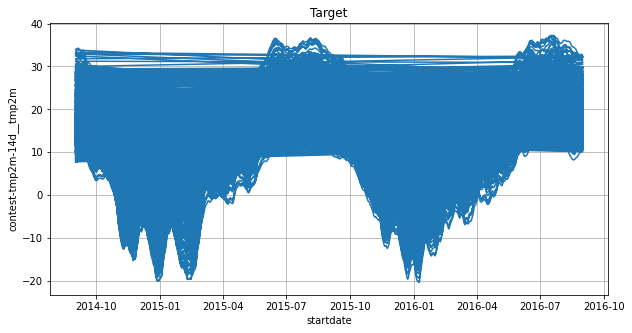

In [58]:
attribute_plot(data, 'startdate', 'contest-tmp2m-14d__tmp2m', 'Target')

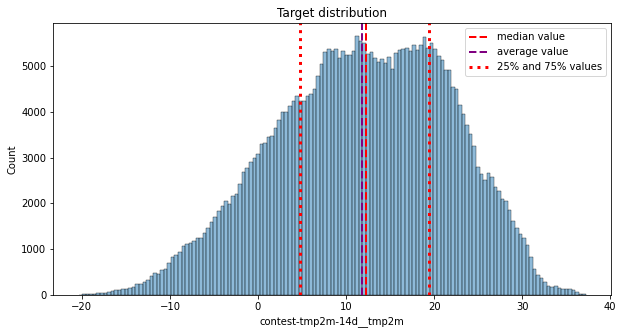

In [59]:
distribution(data, 'contest-tmp2m-14d__tmp2m', 'Target distribution')

The target (temperature) has a distribution similar to the normal. However, the average value is not equal to the median value.

### Locations investigation

In [60]:
# How many locations we have?

data.groupby(['lat', 'lon'], as_index=False, sort=False).aggregate('count')

,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,0.000000,0.833333,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731
1,0.000000,0.866667,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731
2,0.045455,0.833333,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731
3,0.045455,0.866667,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731
4,0.045455,0.900000,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,1.000000,0.733333,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731
510,1.000000,0.766667,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731
511,1.000000,0.800000,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731
512,1.000000,0.833333,731,731,731,731,700,731,731,731,...,731,731,731,731,731,731,731,731,731,731


We have 514 locations and 731 measurements for each of them.

Text(0.5, 1.0, 'Locations')

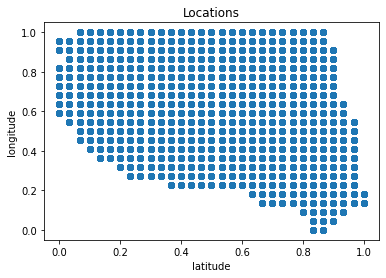

In [61]:
plt.scatter(data['lon'], data['lat'])
plt.xlabel(xlabel='latitude')
plt.ylabel(ylabel='longitude')
plt.title(label='Locations')

### Climatic regions investigation

In [62]:
# How many climatic regions we have?

data.groupby('climateregions__climateregion', as_index=False).aggregate('count')

,climateregions__climateregion,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20
0,BSh,5117,5117,5117,5117,5117,5117,4900,5117,5117,...,5117,5117,5117,5117,5117,5117,5117,5117,5117,5117
1,BSk,139621,139621,139621,139621,139621,139621,133700,139621,139621,...,139621,139621,139621,139621,139621,139621,139621,139621,139621,139621
2,BWh,9503,9503,9503,9503,9503,9503,9100,9503,9503,...,9503,9503,9503,9503,9503,9503,9503,9503,9503,9503
3,BWk,13889,13889,13889,13889,13889,13889,13300,13889,13889,...,13889,13889,13889,13889,13889,13889,13889,13889,13889,13889
4,Cfa,51901,51901,51901,51901,51901,51901,49700,51901,51901,...,51901,51901,51901,51901,51901,51901,51901,51901,51901,51901
5,Cfb,4386,4386,4386,4386,4386,4386,4200,4386,4386,...,4386,4386,4386,4386,4386,4386,4386,4386,4386,4386
6,Csa,9503,9503,9503,9503,9503,9503,9100,9503,9503,...,9503,9503,9503,9503,9503,9503,9503,9503,9503,9503
7,Csb,40936,40936,40936,40936,40936,40936,39200,40936,40936,...,40936,40936,40936,40936,40936,40936,40936,40936,40936,40936
8,Dfa,22661,22661,22661,22661,22661,22661,21700,22661,22661,...,22661,22661,22661,22661,22661,22661,22661,22661,22661,22661
9,Dfb,52632,52632,52632,52632,52632,52632,50400,52632,52632,...,52632,52632,52632,52632,52632,52632,52632,52632,52632,52632


15 climatic regions and different measurements for each of them.

<AxesSubplot:>

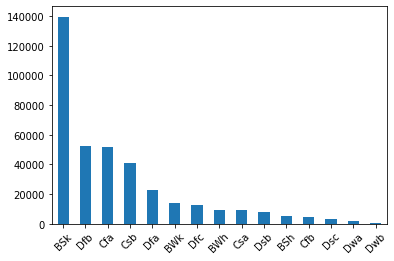

In [63]:
data['climateregions__climateregion'].value_counts().plot(kind='bar', rot=45)

Description:
1. B (Dry):
- BWh = Hot desert climate
- BWk = Cold desert climate
- BSh = Hot semi-arid climate
- BSk = Cold semi-arid climate
2. C (Temperate Climates):
- Cfa = Humid subtropical climate
- Cfb = Temperate oceanic climate or subtropical highland climate
- Csa = Hot-summer Mediterranean climate
- Csb = Warm-summer Mediterranean climate
3. D (Continental climates):
- Dfa = Hot-summer humid continental climate
- Dfb = Warm-summer humid continental climate
- Dwa = Monsoon-influenced hot-summer humid continental climate
- Dwb = Monsoon-influenced warm-summer humid continental climate
- Dsb = Mediterranean-influenced warm-summer humid continental climate
- Dsc = Mediterranean-influenced subarctic climate

Text(0.5, 1.0, 'Locations of the climatic regions')

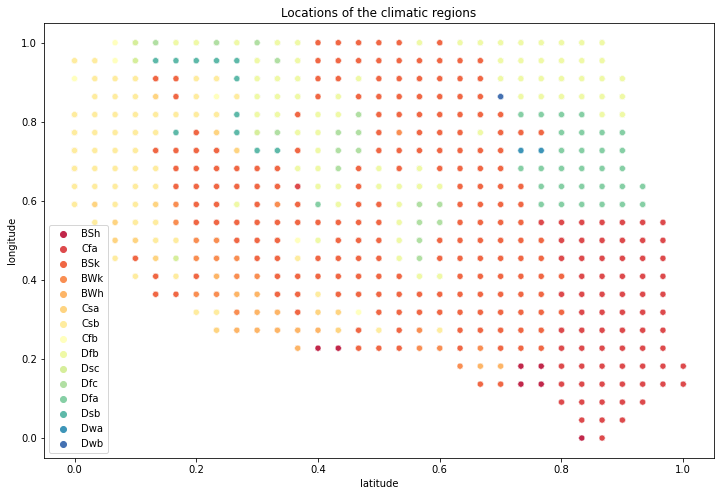

In [64]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=data, x='lon', y='lat', hue = 'climateregions__climateregion', palette = 'Spectral')
plt.legend(loc='best')
plt.xlabel(xlabel='latitude')
plt.ylabel(ylabel='longitude')
plt.title(label='Locations of the climatic regions')

In [65]:
# How many locations in each climatic region?

data['locations'] = data['lat'].astype(str) + '; ' + data['lon'].astype(str)
locations = data[['lat', 'lon', 'climateregions__climateregion', 'locations']].drop_duplicates()
locations.groupby('climateregions__climateregion', as_index=False, sort=False).aggregate({'locations' : 'count'})

,climateregions__climateregion,locations
0,BSh,7
1,Cfa,71
2,BSk,191
3,BWk,19
4,BWh,13
5,Csa,13
6,Csb,56
7,Cfb,6
8,Dfb,72
9,Dsc,4


<AxesSubplot:>

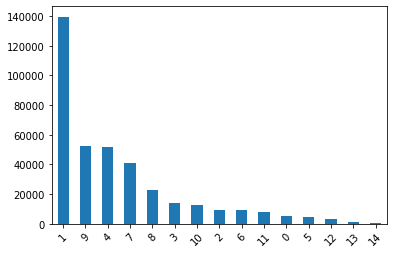

In [66]:
# transform climatic regions from categorical to numeric format to work further

labelencoder = LabelEncoder()
data['climateregions__climateregion'] = labelencoder.fit_transform(data['climateregions__climateregion'].values)

# We can visualize numeric climatic regions to be sure that we have got all 14 regions

data['climateregions__climateregion'].value_counts().plot(kind='bar', rot=45)

In [67]:
# we can also transform locations from (lat; lon) to just numeric format like the climatic regions to simplify the work

data['locations'] = labelencoder.fit_transform(data['locations'].values)
data['locations']

0           8
1           8
2           8
3           8
4           8
         ... 
375729    513
375730    513
375731    513
375732    513
375733    513
Name: locations, Length: 375734, dtype: int64

### Features investigation and selection

For the modeling step, the environmental features were selected by the team through the provided EDA. That is why only these features takes into consideration.

In [68]:
environmental_features = data[['startdate', 'lat', 'lon', 'elevation__elevation', 'climateregions__climateregion', 'locations',\
                           'contest-pevpr-sfc-gauss-14d__pevpr', 'contest-rhum-sig995-14d__rhum', \
                           'contest-slp-14d__slp', 'contest-pres-sfc-gauss-14d__pres', 'contest-prwtr-eatm-14d__prwtr',\
                           'contest-precip-14d__precip', 'contest-wind-h10-14d__wind-hgt-10',\
                     'contest-wind-h100-14d__wind-hgt-100', 'contest-wind-h500-14d__wind-hgt-500', \
                     'contest-wind-h850-14d__wind-hgt-850', 'contest-wind-vwnd-250-14d__wind-vwnd-250',\
                     'contest-wind-vwnd-925-14d__wind-vwnd-925','contest-wind-uwnd-250-14d__wind-uwnd-250',\
                     'contest-wind-uwnd-925-14d__wind-uwnd-925', 'contest-tmp2m-14d__tmp2m']]

# rename some features for the clear description

environmental_features = environmental_features.rename(columns={'elevation__elevation': 'elevation', \
                                                                'climateregions__climateregion': 'climateregion',\
                                                               'contest-pevpr-sfc-gauss-14d__pevpr': 'evaporation',\
                                                               'contest-rhum-sig995-14d__rhum': 'humidity',\
                                                               'contest-slp-14d__slp': 'sea_level_pressure',\
                                                               'contest-pres-sfc-gauss-14d__pres': 'pressure',\
                                                               'contest-prwtr-eatm-14d__prwtr': 'precipitable_water',
                                                               'contest-precip-14d__precip': 'precipitation',\
                                                               'contest-wind-h10-14d__wind-hgt-10': 'wind_height_10',\
                                                               'contest-wind-h100-14d__wind-hgt-100': 'wind_height_100',\
                                                               'contest-wind-h500-14d__wind-hgt-500': 'wind_height_500',\
                                                               'contest-wind-h850-14d__wind-hgt-850': 'wind_height_850',\
                                                               'contest-wind-vwnd-250-14d__wind-vwnd-250': \
                                                                'long_wind_250', 'contest-wind-vwnd-925-14d__wind-vwnd-925':\
                                                               'long_wind_925', 'contest-wind-uwnd-250-14d__wind-uwnd-250':\
                                                               'zonal_wind_250', 'contest-wind-uwnd-925-14d__wind-uwnd-925':\
                                                               'zonal_wind_925', 'contest-tmp2m-14d__tmp2m': 'temperature'})

# five point summary

environmental_features.drop(columns={'startdate', 'lat', 'lon', 'climateregion', 'locations'}).describe().T

,count,mean,std,min,25%,50%,75%,max
elevation,375734.0,1078.657588,669.219573,0.000000,500.000000,900.00000,1700.00000,3100.000000
evaporation,375734.0,276.744064,198.085182,-2.310000,104.062500,250.32000,420.01000,1185.140000
humidity,375734.0,62.766512,17.399704,13.250000,50.090000,64.91000,77.41000,98.220000
sea_level_pressure,375734.0,101605.888627,406.331364,100379.210000,101306.620000,101511.24500,101844.87000,103275.840000
pressure,375734.0,89235.103399,6509.231609,74839.940000,83598.717500,89444.93000,94683.83000,102845.570000
precipitable_water,375734.0,14.298038,8.142212,2.700000,8.350000,12.05000,17.82000,52.660000
precipitation,375734.0,22.859842,32.109036,0.000000,3.790000,12.18000,28.84000,502.630000
wind_height_10,375734.0,31071.557568,343.019882,29943.150000,30811.990000,31016.82000,31374.78000,31803.030000
wind_height_100,375734.0,16404.561991,196.007401,15750.120000,16252.322500,16381.73000,16585.42750,16762.800000
wind_height_500,375734.0,5728.370672,123.805703,5289.250000,5644.070000,5732.22000,5827.68000,5958.200000


<AxesSubplot:>

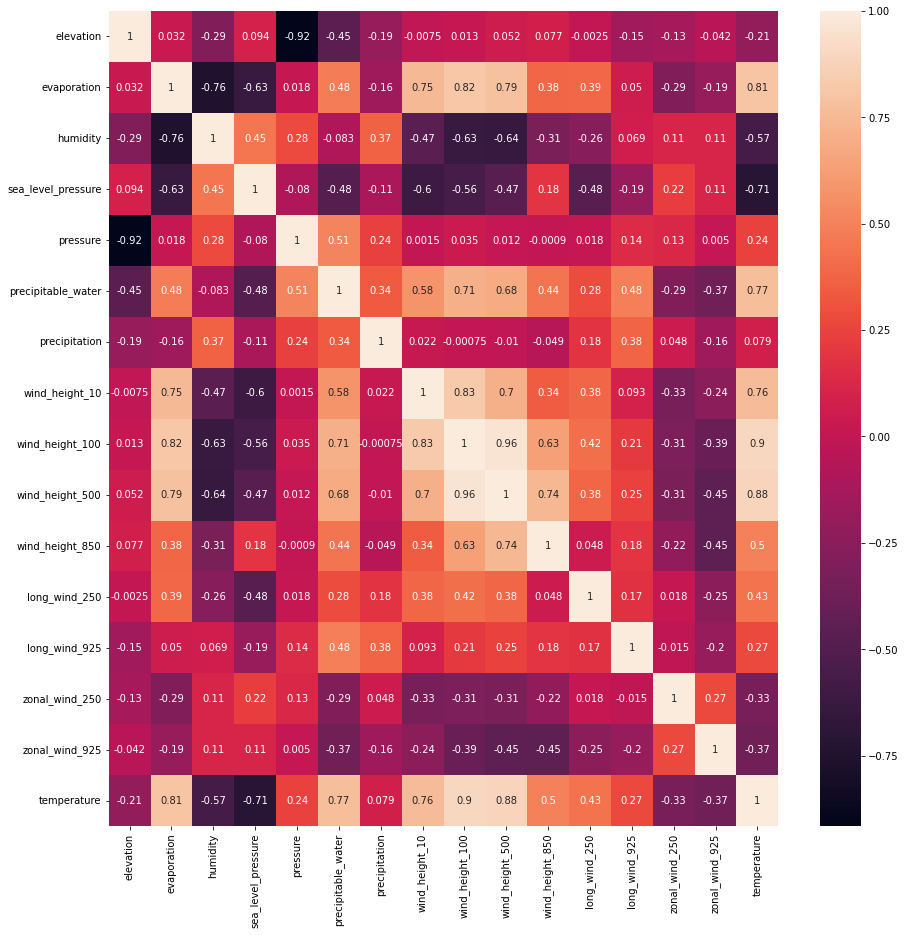

In [69]:
plt.figure(figsize=(15,15))
corr_matrix = environmental_features.drop(columns={'startdate', 'lat', 'lon', 'climateregion', 'locations'}).corr()
sns.heatmap(corr_matrix, annot=True)

The heatmap shows that
1. we have high correlation between some features (|correlation|> 0.75):
- elevation and pressure = -0.92
- evaporation and humidity = -0.76
- evaporation and wind height 10 = 0.75
- wind height 10 and wind height 100 = 0.83
- evaporation and wind height 100 = 0.82
- evaporation and wind height 500 = 0.79
- wind height 100 and wind height 500 = 0.96
2. we have high correlation between temperature and 
- evaporation = 0.81
- precipitable water = 0.77
- wind height 10 = 0.76
- wind height 100 = 0.9
- wind height 500 = 0.88
3. we have low correlation (|correlation|< 0.5) between temperature and
- precipitation = 0.079
- elevation = -0.21
- pressure = 0.24
- longitudinal wind 250 = 0.43
- longitudinal wind 925 = 0.27
- zonal wind 250 = -0.33
- zonal wind 925 = -0.37

The variables must be independent between each other. Therefore the high correlated features should be excluded at the modeling stage. The low correlated features should be also excluded as the less informative.
We can remove wind height 10 and wind height 500. Although evaporation and temperature are high correlated we can also try to remove evaporation because of its high correlation with humidity and wind height 100, and observe what we will get.

In [70]:
environmental_features_selected = environmental_features.drop(columns={'evaporation', 'wind_height_10', 'wind_height_500',\
                                                                       'elevation', 'precipitation', 'pressure',\
                                                                       'long_wind_250', 'long_wind_925', 'zonal_wind_250',
                                                                       'zonal_wind_925'})

<AxesSubplot:>

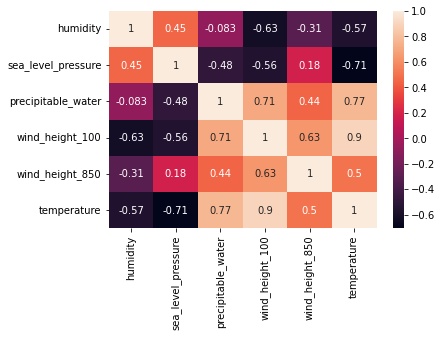

In [71]:
corr_matrix_selected = environmental_features_selected.drop(columns={'lat', 'lon', 'startdate', 'climateregion', 'locations'})\
.corr()
sns.heatmap(corr_matrix_selected, annot=True)

We have got 5 features.

array([[<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>]], dtype=object)

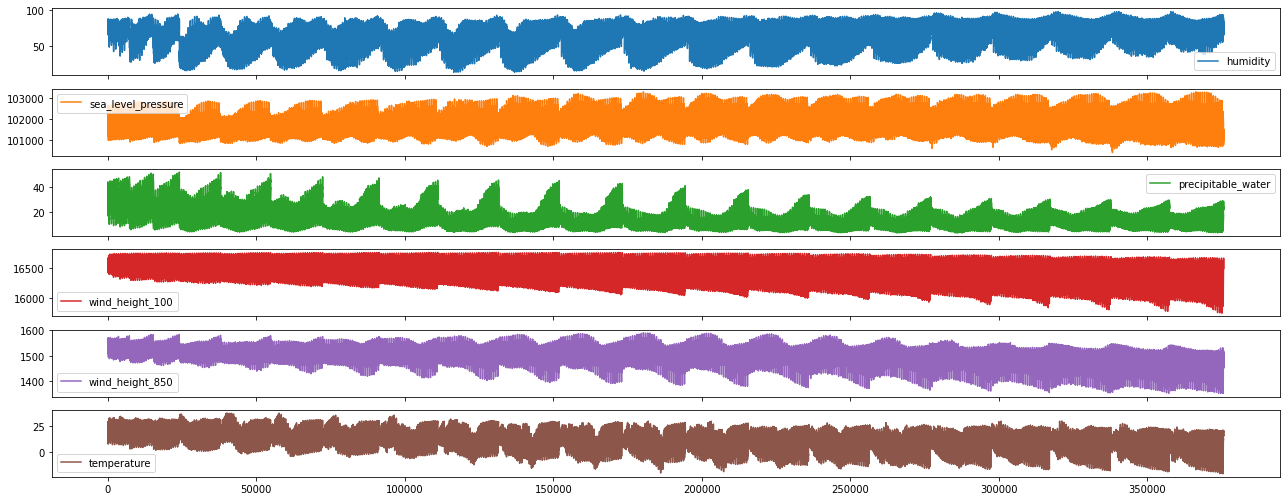

In [72]:
# features simple visualization

environmental_features_selected.drop(columns={'lat', 'lon', 'startdate', 'climateregion', 'locations'})\
.plot(figsize = (22, 16), subplots=True, layout=(len(environmental_features_selected.columns),1)) 

We have 514 locations and 14 climatic regions. The measurements are spread on the graphs through the whole time period.

To try modeling step and interpret the results correctly, we can start simply from one location. Location # 1 for instance.

### Single location

In [73]:
location_number = 10 # choose the number of location
single_location = environmental_features_selected[environmental_features_selected['locations'] == location_number]
single_location.head()

,startdate,lat,lon,climateregion,locations,humidity,sea_level_pressure,precipitable_water,wind_height_100,wind_height_850,temperature
7310,2014-09-01,0.136364,0.666667,1,10,74.94,101289.29,32.73,16682.11,1518.69,23.050159
7311,2014-09-02,0.136364,0.666667,1,10,78.04,101349.20,33.88,16682.90,1522.12,22.645597
7312,2014-09-03,0.136364,0.666667,1,10,81.40,101402.42,35.34,16684.70,1525.84,22.382765
7313,2014-09-04,0.136364,0.666667,1,10,83.06,101424.82,36.33,16684.99,1527.41,22.242047
7314,2014-09-05,0.136364,0.666667,1,10,83.50,101422.60,36.52,16684.26,1527.29,22.305799


array([[<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>]], dtype=object)

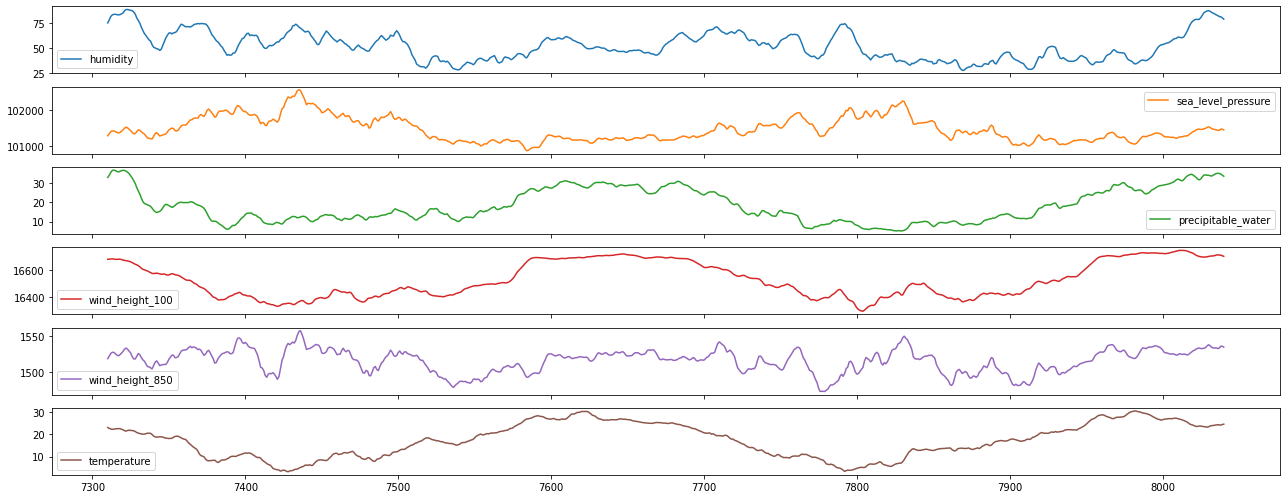

In [74]:
# features simple visualization

single_location.drop(columns={'lat', 'lon', 'startdate', 'climateregion', 'locations'})\
.plot(figsize = (22, 16), subplots=True, layout=(len(single_location.columns),1)) 

Now we can see variables dynamic for location # 1

and their distributions:

array([[<AxesSubplot:title={'center':'humidity'}>],
       [<AxesSubplot:title={'center':'sea_level_pressure'}>],
       [<AxesSubplot:title={'center':'precipitable_water'}>],
       [<AxesSubplot:title={'center':'wind_height_100'}>],
       [<AxesSubplot:title={'center':'wind_height_850'}>],
       [<AxesSubplot:title={'center':'temperature'}>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>],
       [<AxesSubplot:>]], dtype=object)

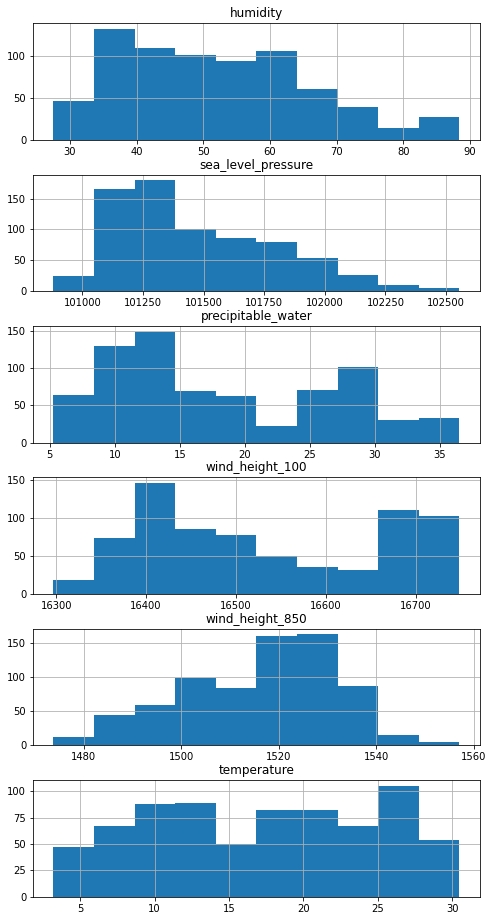

In [75]:
single_location.drop(columns={'lat', 'lon', 'startdate', 'climateregion', 'locations'})\
.hist(figsize = (8, 30), layout=(len(single_location.columns),1)) 

### Features preparations to the modeling step

In [76]:
# we take only date and necessary features for the prediction

single_location = single_location.drop(columns={'lat', 'lon', 'climateregion', 'locations'}).set_index('startdate')
single_location.head()

,humidity,sea_level_pressure,precipitable_water,wind_height_100,wind_height_850,temperature
startdate,,,,,,
2014-09-01,74.94,101289.29,32.73,16682.11,1518.69,23.050159
2014-09-02,78.04,101349.20,33.88,16682.90,1522.12,22.645597
2014-09-03,81.40,101402.42,35.34,16684.70,1525.84,22.382765
2014-09-04,83.06,101424.82,36.33,16684.99,1527.41,22.242047
2014-09-05,83.50,101422.60,36.52,16684.26,1527.29,22.305799


In [77]:
#single_location.dtypes
environmental_features_selected.dtypes

startdate             datetime64[ns]
lat                          float64
lon                          float64
climateregion                  int64
locations                      int64
humidity                     float64
sea_level_pressure           float64
precipitable_water           float64
wind_height_100              float64
wind_height_850              float64
temperature                  float64
dtype: object

In [78]:
# normalizing the features

scaler = MinMaxScaler()
environmental_features_selected = environmental_features_selected.drop(columns={'lat', 'lon', 'climateregion', 'locations'}).set_index('startdate')
dataset = scaler.fit_transform(single_location)
#dataset = scaler.fit_transform(environmental_features_selected)
print(single_location.shape)

(731, 6)


This tutorial was used for the futher work:
https://www.kaggle.com/code/mineshjethva/time-series-forecasting-with-lstm-for-uni-multivar/notebook

We are going to use a multivariate approach since we have 5 features and the temperature itself.

To lean by steps, firstly we will try to predict the values of the temperature for the next 14 days for one location by building LSTM model.

We have 731 observations and one measurement per day. 
In order to make this prediction, we choose to use 7 days of observations (is chosen via experiments for the model as an optimal one). 
Thus, we would create a window containing the last 7 observations to train the model.

In [79]:
# The function below returns the above described windows of time for the model to train on

# history_size is the size of the past window of information
# target_size is how far in the future does the model need to learn to predict, is the label that needs to be predicted

def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step):
# "multivariate" means that we use several features (not one)
    data = [] # for x_train/validation
    labels = [] # for y_train/validation
    start_index = start_index + history_size
    
    if end_index is None: # for the validation part
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index): # sequences creation 
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])
        
    return np.array(data), np.array(labels)

We do not use our test dataset and split the training dataset into training and validation parts to adjust the model.

In [80]:
# setting the inputs for the function

training_size = int(0.8*dataset.shape[0]) # define the size of training part
start_index = 0
end_index = training_size
history_size = 7 # is the size of the past window of information
target_size = 14 # days, is how far in the future does the model need to learn to predict, 
#is the label that needs to be predicted
step = 1 # we have one measurement per day that is one day

In [81]:
# splitting the dataset into training and validation parts and transforming it with the described window

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, -1], start_index, end_index, history_size, target_size,\
                                                 step)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, -1], start_index, None, history_size, target_size, step)

Now we are ready to build a model.

### Building LSTM model

In [82]:
# functions for plotting the results

# creating time steps for plotting
def create_time_steps(length):
    return list(range(-length, 0))

# plotting predictions
def multi_step_plot(history, true_future, prediction, title):
    plt.figure(figsize=(10, 5))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, -1]), label='History')
    plt.plot(np.arange(num_out)/step, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'ro', label='Predicted Future')
    plt.ylim(top=1, bottom=0)
    plt.legend(loc='lower left')
    plt.title(title)
    plt.savefig('prediction_plot.png', facecolor='w', edgecolor='w')
    
# plotting loss results    
def plot_train_history(history, title):
    # the loss is mse in the model configuration, and we calculate rmse by tf.sqrt for the task goal
    loss = tf.sqrt(history.history['loss']) 
    val_loss = tf.sqrt(history.history['val_loss'])

    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.ylim(top=0.2)
    plt.title(title)
    plt.savefig('loss_plot.png', facecolor='w', edgecolor='w')

In [83]:
# We use tensorflow and keras to work with LSTM

# perform shuffling, batching, and caching the dataset

BATCH_SIZE = 16 # is chosen via experiments for the model as an optimal one
# about batch size https://ai.stackexchange.com/questions/8560/how-do-i-choose-the-optimal-batch-size
BUFFER_SIZE = 10000 # 10000 in tutorial
# about buffer size 
#https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [85]:
res = {}

for j in ['tanh', 'relu', 'softmax', 'sigmoid']:
  for i in [20, 30, 45, 50, 64]:
    print("currently " + str(i) + " neurons")

    # constructing the model

    multi_step_model = tf.keras.models.Sequential() # layers creating 
    # the first layer
    # activation functions are 'tanh' and recurrent_activation='sigmoid'
    multi_step_model.add(tf.keras.layers.LSTM(i, # 32 neurons in tutorial
                                              activation= j,
                                              input_shape=x_train_multi.shape[-2:])) 
    '''
    # the second layer
    multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)) # 32 neurons, activation 'relu' in tutorial
    multi_step_model.add(tf.keras.layers.LSTM(16, activation='softmax')) # 32 neurons, activation 'relu' in tutorial
    '''
    # the output layer
    multi_step_model.add(tf.keras.layers.Dense(14)) # since 14 predictions are made 
    # the dense layer outputs 14 predictions

    # configures the model for training
    multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse', metrics=['accuracy']) # learning_rate=0.001 as default
    # clipvalue: If set, the gradient of each weight is clipped to be no higher than this value

    #print(multi_step_model.summary())

    '''
    # how the model predicts before it trains
    for x, y in val_data_multi.take(1): # .take () creates a dataset with at most count elements from this dataset
        # representing the number of elements of this dataset that should be taken to form the new dataset
        print (multi_step_model.predict(x).shape)
    '''

    # training the model

    EVALUATION_INTERVAL = training_size 
    # steps per epoch is calculated as train_length // batch_size, 200 in tutorial (is said that complete training data is normal)
    EPOCHS = 20 # 20 in tutorial

    multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                              steps_per_epoch=EVALUATION_INTERVAL,
                                              validation_data=val_data_multi,
                                              validation_steps=50) 
    # validation_steps = total_validation_samples // validation_batch_size
    # validation_batch_size If unspecified, will default to batch_size
    print("++++++++++++++++++++++++++++++++++++++++++++")
    print((j, i, multi_step_history.history['accuracy'][-1]))
    print("\n")
    res[(j, i)] = multi_step_history.history['accuracy'][-1]
print("\n")
print("THE RESULT IS")
print("\n")
print(res)

currently 20 neurons
Epoch 1/20
584/584 [==============================] - 7s 7ms/step - loss: 0.0174 - accuracy: 0.1143 - val_loss: 0.0051 - val_accuracy: 0.1456
Epoch 2/20
584/584 [==============================] - 3s 6ms/step - loss: 0.0050 - accuracy: 0.1610 - val_loss: 0.0045 - val_accuracy: 0.1810
Epoch 3/20
584/584 [==============================] - 3s 5ms/step - loss: 0.0044 - accuracy: 0.1693 - val_loss: 0.0039 - val_accuracy: 0.1506
Epoch 4/20
584/584 [==============================] - 3s 5ms/step - loss: 0.0040 - accuracy: 0.1891 - val_loss: 0.0036 - val_accuracy: 0.1646
Epoch 5/20
584/584 [==============================] - 4s 7ms/step - loss: 0.0036 - accuracy: 0.2182 - val_loss: 0.0030 - val_accuracy: 0.2519
Epoch 6/20
584/584 [==============================] - 3s 6ms/step - loss: 0.0032 - accuracy: 0.2487 - val_loss: 0.0029 - val_accuracy: 0.2304
Epoch 7/20
584/584 [==============================] - 3s 5ms/step - loss: 0.0029 - accuracy: 0.2663 - val_loss: 0.0025 - val_ac

In [87]:
res = {}
res_l = {'tanh':[], 'relu':[]}

for j in ['tanh', 'relu']:
  for i in range(20, 65):
    print("currently " + str(i) + " neurons")

    # constructing the model

    multi_step_model = tf.keras.models.Sequential() # layers creating 
    # the first layer
    # activation functions are 'tanh' and recurrent_activation='sigmoid'
    multi_step_model.add(tf.keras.layers.LSTM(i, # 32 neurons in tutorial
                                              activation= j,
                                              input_shape=x_train_multi.shape[-2:])) 
    '''
    # the second layer
    multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)) # 32 neurons, activation 'relu' in tutorial
    multi_step_model.add(tf.keras.layers.LSTM(16, activation='softmax')) # 32 neurons, activation 'relu' in tutorial
    '''
    # the output layer
    multi_step_model.add(tf.keras.layers.Dense(14)) # since 14 predictions are made 
    # the dense layer outputs 14 predictions

    # configures the model for training
    multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse', metrics=['accuracy']) # learning_rate=0.001 as default
    # clipvalue: If set, the gradient of each weight is clipped to be no higher than this value

    #print(multi_step_model.summary())

    '''
    # how the model predicts before it trains
    for x, y in val_data_multi.take(1): # .take () creates a dataset with at most count elements from this dataset
        # representing the number of elements of this dataset that should be taken to form the new dataset
        print (multi_step_model.predict(x).shape)
    '''

    # training the model

    EVALUATION_INTERVAL = training_size 
    # steps per epoch is calculated as train_length // batch_size, 200 in tutorial (is said that complete training data is normal)
    EPOCHS = 20 # 20 in tutorial

    multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                              steps_per_epoch=EVALUATION_INTERVAL,
                                              validation_data=val_data_multi,
                                              validation_steps=50) 
    # validation_steps = total_validation_samples // validation_batch_size
    # validation_batch_size If unspecified, will default to batch_size
    res[(j, i)] = multi_step_history.history['accuracy'][-1]
    res_l[j].append(multi_step_history.history['accuracy'][-1])
print("\n")
print("THE RESULT IS")
print("\n")
print(res)
print(res_l)

currently 20 neurons
Epoch 1/20
584/584 [==============================] - 8s 7ms/step - loss: 0.0203 - accuracy: 0.1567 - val_loss: 0.0055 - val_accuracy: 0.1519
Epoch 2/20
584/584 [==============================] - 3s 5ms/step - loss: 0.0053 - accuracy: 0.1985 - val_loss: 0.0056 - val_accuracy: 0.2089
Epoch 3/20
584/584 [==============================] - 3s 5ms/step - loss: 0.0047 - accuracy: 0.2245 - val_loss: 0.0043 - val_accuracy: 0.2101
Epoch 4/20
584/584 [==============================] - 4s 7ms/step - loss: 0.0043 - accuracy: 0.2358 - val_loss: 0.0040 - val_accuracy: 0.2544
Epoch 5/20
584/584 [==============================] - 3s 5ms/step - loss: 0.0039 - accuracy: 0.2353 - val_loss: 0.0043 - val_accuracy: 0.1557
Epoch 6/20
584/584 [==============================] - 3s 5ms/step - loss: 0.0036 - accuracy: 0.2264 - val_loss: 0.0031 - val_accuracy: 0.2557
Epoch 7/20
584/584 [==============================] - 3s 6ms/step - loss: 0.0032 - accuracy: 0.2255 - val_loss: 0.0030 - val_ac

In [96]:
# constructing the model

multi_step_model = tf.keras.models.Sequential() # layers creating 
# the first layer
# activation functions are 'tanh' and recurrent_activation='sigmoid'
multi_step_model.add(tf.keras.layers.LSTM(50, # 32 neurons in tutorial
                                          activation= 'relu',
                                          input_shape=x_train_multi.shape[-2:])) 
'''
# the second layer
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)) # 32 neurons, activation 'relu' in tutorial
multi_step_model.add(tf.keras.layers.LSTM(16, activation='softmax')) # 32 neurons, activation 'relu' in tutorial
'''
# the output layer
multi_step_model.add(tf.keras.layers.Dense(14)) # since 14 predictions are made 
# the dense layer outputs 14 predictions

# configures the model for training
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse', metrics=['accuracy']) # learning_rate=0.001 as default
# clipvalue: If set, the gradient of each weight is clipped to be no higher than this value

#print(multi_step_model.summary())

'''
# how the model predicts before it trains
for x, y in val_data_multi.take(1): # .take () creates a dataset with at most count elements from this dataset
    # representing the number of elements of this dataset that should be taken to form the new dataset
    print (multi_step_model.predict(x).shape)
'''

# training the model

EVALUATION_INTERVAL = training_size 
# steps per epoch is calculated as train_length // batch_size, 200 in tutorial (is said that complete training data is normal)
EPOCHS = 30 # 20 in tutorial

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50) 

Epoch 1/30
584/584 [==============================] - 8s 6ms/step - loss: 0.0168 - accuracy: 0.1875 - val_loss: 0.0054 - val_accuracy: 0.2873
Epoch 2/30
584/584 [==============================] - 3s 6ms/step - loss: 0.0049 - accuracy: 0.2682 - val_loss: 0.0043 - val_accuracy: 0.3165
Epoch 3/30
584/584 [==============================] - 4s 7ms/step - loss: 0.0041 - accuracy: 0.3051 - val_loss: 0.0034 - val_accuracy: 0.3456
Epoch 4/30
584/584 [==============================] - 4s 6ms/step - loss: 0.0035 - accuracy: 0.3227 - val_loss: 0.0032 - val_accuracy: 0.3519
Epoch 5/30
584/584 [==============================] - 3s 5ms/step - loss: 0.0029 - accuracy: 0.3264 - val_loss: 0.0043 - val_accuracy: 0.3190
Epoch 6/30
584/584 [==============================] - 3s 5ms/step - loss: 0.0025 - accuracy: 0.3480 - val_loss: 0.0023 - val_accuracy: 0.3190
Epoch 7/30
584/584 [==============================] - 4s 7ms/step - loss: 0.0022 - accuracy: 0.3629 - val_loss: 0.0018 - val_accuracy: 0.3962
Epoch 

In [97]:
# constructing the model

multi_step_model = tf.keras.models.Sequential() # layers creating 
# the first layer
# activation functions are 'tanh' and recurrent_activation='sigmoid'
multi_step_model.add(tf.keras.layers.LSTM(50, # 32 neurons in tutorial
                                          activation= 'relu',
                                          input_shape=x_train_multi.shape[-2:])) 
'''
# the second layer
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)) # 32 neurons, activation 'relu' in tutorial
multi_step_model.add(tf.keras.layers.LSTM(16, activation='softmax')) # 32 neurons, activation 'relu' in tutorial
'''
# the output layer
multi_step_model.add(tf.keras.layers.Dense(14)) # since 14 predictions are made 
# the dense layer outputs 14 predictions

# configures the model for training
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse', metrics=['accuracy']) # learning_rate=0.001 as default
# clipvalue: If set, the gradient of each weight is clipped to be no higher than this value

#print(multi_step_model.summary())

'''
# how the model predicts before it trains
for x, y in val_data_multi.take(1): # .take () creates a dataset with at most count elements from this dataset
    # representing the number of elements of this dataset that should be taken to form the new dataset
    print (multi_step_model.predict(x).shape)
'''

# training the model

EVALUATION_INTERVAL = training_size 
# steps per epoch is calculated as train_length // batch_size, 200 in tutorial (is said that complete training data is normal)
EPOCHS = 30 # 20 in tutorial

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50) 

Epoch 1/30
584/584 [==============================] - 6s 7ms/step - loss: 0.0148 - accuracy: 0.1759 - val_loss: 0.0052 - val_accuracy: 0.2937
Epoch 2/30
584/584 [==============================] - 7s 11ms/step - loss: 0.0051 - accuracy: 0.2833 - val_loss: 0.0043 - val_accuracy: 0.3177
Epoch 3/30
584/584 [==============================] - 3s 6ms/step - loss: 0.0043 - accuracy: 0.3031 - val_loss: 0.0044 - val_accuracy: 0.3190
Epoch 4/30
584/584 [==============================] - 4s 6ms/step - loss: 0.0037 - accuracy: 0.3078 - val_loss: 0.0034 - val_accuracy: 0.3203
Epoch 5/30
584/584 [==============================] - 4s 6ms/step - loss: 0.0031 - accuracy: 0.3051 - val_loss: 0.0027 - val_accuracy: 0.3190
Epoch 6/30
584/584 [==============================] - 3s 5ms/step - loss: 0.0026 - accuracy: 0.3372 - val_loss: 0.0026 - val_accuracy: 0.3380
Epoch 7/30
584/584 [==============================] - 3s 6ms/step - loss: 0.0022 - accuracy: 0.3776 - val_loss: 0.0026 - val_accuracy: 0.2949
Epoch

In [98]:
# constructing the model

multi_step_model = tf.keras.models.Sequential() # layers creating 
# the first layer
# activation functions are 'tanh' and recurrent_activation='sigmoid'
multi_step_model.add(tf.keras.layers.LSTM(50, # 32 neurons in tutorial
                                          activation= 'relu',
                                          input_shape=x_train_multi.shape[-2:])) 
'''
# the second layer
multi_step_model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True)) # 32 neurons, activation 'relu' in tutorial
multi_step_model.add(tf.keras.layers.LSTM(16, activation='softmax')) # 32 neurons, activation 'relu' in tutorial
'''
# the output layer
multi_step_model.add(tf.keras.layers.Dense(14)) # since 14 predictions are made 
# the dense layer outputs 14 predictions

# configures the model for training
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse', metrics=['accuracy']) # learning_rate=0.001 as default
# clipvalue: If set, the gradient of each weight is clipped to be no higher than this value


In [99]:
multi_step_model.summary()

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_123 (LSTM)             (None, 50)                11400     
                                                                 
 dense_123 (Dense)           (None, 14)                714       
                                                                 
Total params: 12,114
Trainable params: 12,114
Non-trainable params: 0
_________________________________________________________________


In [100]:
# how the model predicts before it trains

for x, y in val_data_multi.take(1): # .take () creates a dataset with at most count elements from this dataset
    # representing the number of elements of this dataset that should be taken to form the new dataset
    print (multi_step_model.predict(x).shape)

1/1 [==============================] - 0s 385ms/step
(16, 14)


1/1 [==============================] - 0s 30ms/step


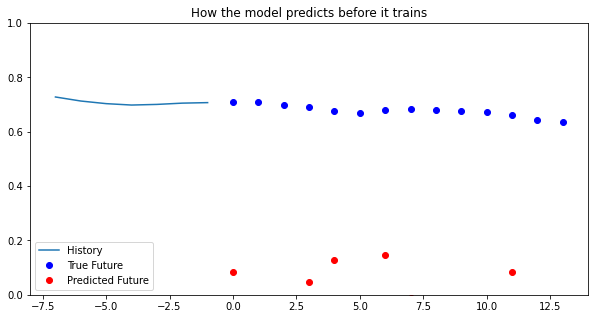

In [101]:
multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], 'How the model predicts before it trains')

In [108]:
# training the model

EVALUATION_INTERVAL = training_size 
# steps per epoch is calculated as train_length // batch_size, 200 in tutorial (is said that complete training data is normal)
EPOCHS = 30 # 20 in tutorial

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50) 
# validation_steps = total_validation_samples // validation_batch_size
# validation_batch_size If unspecified, will default to batch_size

Epoch 1/30
584/584 [==============================] - 5s 8ms/step - loss: 1.3615e-04 - accuracy: 0.6055 - val_loss: 0.0014 - val_accuracy: 0.5873
Epoch 2/30
584/584 [==============================] - 4s 6ms/step - loss: 1.3705e-04 - accuracy: 0.6098 - val_loss: 0.0016 - val_accuracy: 0.5861
Epoch 3/30
584/584 [==============================] - 4s 6ms/step - loss: 1.3766e-04 - accuracy: 0.6028 - val_loss: 0.0016 - val_accuracy: 0.5772
Epoch 4/30
584/584 [==============================] - 5s 8ms/step - loss: 1.3536e-04 - accuracy: 0.6022 - val_loss: 0.0015 - val_accuracy: 0.6000
Epoch 5/30
584/584 [==============================] - 4s 7ms/step - loss: 1.3510e-04 - accuracy: 0.6082 - val_loss: 0.0014 - val_accuracy: 0.5861
Epoch 6/30
584/584 [==============================] - 4s 6ms/step - loss: 1.3670e-04 - accuracy: 0.6084 - val_loss: 0.0015 - val_accuracy: 0.5671
Epoch 7/30
584/584 [==============================] - 4s 8ms/step - loss: 1.3294e-04 - accuracy: 0.6033 - val_loss: 0.0015 -

In [112]:
# training the model

EVALUATION_INTERVAL = training_size 
# steps per epoch is calculated as train_length // batch_size, 200 in tutorial (is said that complete training data is normal)
EPOCHS = 30 # 20 in tutorial

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50) 
# validation_steps = total_validation_samples // validation_batch_size
# validation_batch_size If unspecified, will default to batch_size

Epoch 1/30
584/584 [==============================] - 4s 7ms/step - loss: 8.8181e-05 - accuracy: 0.6272 - val_loss: 0.0011 - val_accuracy: 0.6013
Epoch 2/30
584/584 [==============================] - 4s 6ms/step - loss: 8.8256e-05 - accuracy: 0.6316 - val_loss: 0.0012 - val_accuracy: 0.6165
Epoch 3/30
584/584 [==============================] - 4s 7ms/step - loss: 8.7672e-05 - accuracy: 0.6225 - val_loss: 0.0013 - val_accuracy: 0.5975
Epoch 4/30
584/584 [==============================] - 4s 7ms/step - loss: 8.6527e-05 - accuracy: 0.6292 - val_loss: 0.0012 - val_accuracy: 0.5835
Epoch 5/30
584/584 [==============================] - 4s 6ms/step - loss: 8.6374e-05 - accuracy: 0.6273 - val_loss: 0.0012 - val_accuracy: 0.6152
Epoch 6/30
584/584 [==============================] - 4s 6ms/step - loss: 8.6221e-05 - accuracy: 0.6269 - val_loss: 0.0012 - val_accuracy: 0.5886
Epoch 7/30
584/584 [==============================] - 4s 8ms/step - loss: 8.7251e-05 - accuracy: 0.6306 - val_loss: 0.0012 -

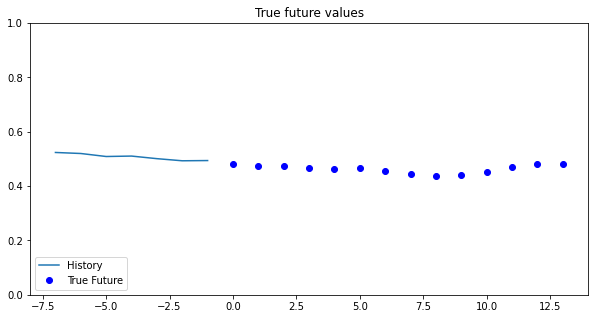

In [113]:
# the history and the future data are sampled every day
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]), 'True future values')

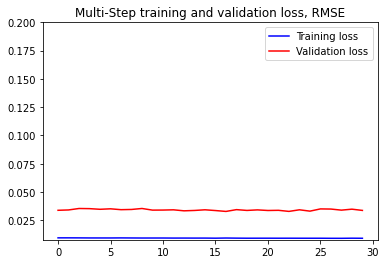

In [114]:
# loss function results
plot_train_history(multi_step_history, 'Multi-Step training and validation loss, RMSE')

1/1 [==============================] - 0s 48ms/step


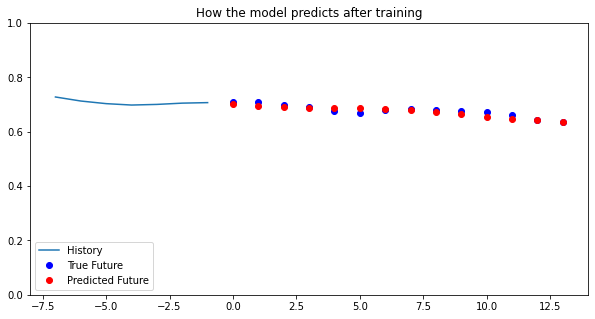

In [115]:
# the history, the true and predicted future data are sampled every day
for x, y in val_data_multi.take(1): 
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0], 'How the model predicts after training')

1/1 [==============================] - 0s 46ms/step


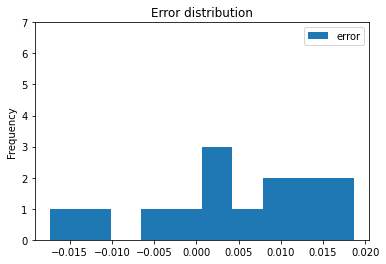

In [116]:
# plotting error distribution for 14 predictions
error = pd.DataFrame({'error':y[0] - multi_step_model.predict(x)[0]})
error = error.reset_index()
error = error.drop(columns=['index'])
error.plot.hist()
plt.ylim(top=7)
plt.title('Error distribution')
plt.savefig('error_distribution.png', facecolor='w', edgecolor='w')